In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as tck
from scipy import integrate
import os

#!pip install PyPDF2
#!pip install natsort
from PyPDF2 import PdfWriter
from natsort import natsorted

In [2]:
def absFFT(times, amplitude):
    fourierTransform = np.fft.fft(amplitude)/len(amplitude)
    fourierTransform = fourierTransform[range(int(len(amplitude)/2))]
    samplingFrequency = 1/((times[-1]-times[0])/len(times))
    tpCount     = len(amplitude)
    values      = np.arange(int(tpCount/2))
    timePeriod  = tpCount/samplingFrequency
    frequencies = values/timePeriod
    return frequencies, abs(fourierTransform)

In [3]:
def integrate_fft(freq_array, power_array, cutoff_freq):
    mask = (freq_array[:] <= cutoff_freq)
    sub_freq_array, sub_power_array = freq_array[mask], power_array[mask]
    area = integrate.simps(sub_power_array, sub_freq_array)
    return area

# Single Plot

In [28]:
def plot_data_fft_single(times, data1, title, cutoff_f, log=True, save=False):
    data_mean, data_std = np.mean(data1), np.std(data1)
    
    freq_1, power_1 = absFFT(times, data1)
    freq_1, power_1 = freq_1[1:], power_1[1:]
    area = integrate_fft(freq_array, power_array, cutoff_f)
    
    data_text = r'Mean: {:.4f} $\pm$ {:.4f} V'.format(data_mean, data_std)

    fig, ax = plt.subplots(1, 2, figsize=(24, 8))
    ax[0].plot(times, data1, label=f'Input Signal\n'+data_text, c='red')
    ax[1].plot(freq_1, power_1, label='Input Signal'+f'\n Area [0, {cutoff_f}Hz] = {area:.4f}', c='g')
    
    plt.suptitle(title, fontsize=20, y=0.95) 
    time_min, time_max = np.min(times), np.max(times)
    data1_min, data1_max = np.min(data1), np.max(data1)
    ax[0].set(ylim=(data1_min-0.1, data1_max+0.1))
    #ax[0].set(ylim=(3, 3.2))
    
    ax[0].legend(loc='upper right', fontsize=16)
    ax[0].set(xlabel='Time (s)', ylabel='Voltage (V)', xlim=(time_min, time_max))
    ax[0].tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=16)
    ax[0].xaxis.set_minor_locator(tck.AutoMinorLocator())
    ax[0].yaxis.set_minor_locator(tck.AutoMinorLocator())
    ax[0].xaxis.label.set_size(20)
    ax[0].yaxis.label.set_size(20)
    
        
    ax[1].legend(loc='upper left', fontsize=16)
    #ax[1].set(xlabel='Frequency (Hz)', ylabel='Power', ylim=(0, 0.002)) #, xlim=(0, 200)
    ax[1].tick_params(axis='both', which='both', direction='in',
                      top=True, right=True, labelsize=16)
    ax[1].xaxis.set_minor_locator(tck.AutoMinorLocator())
    ax[1].yaxis.set_minor_locator(tck.AutoMinorLocator())
    ax[1].xaxis.label.set_size(20)
    ax[1].yaxis.label.set_size(20)

    if log:
        ax[1].set_yscale('log')
        ax[1].set_xscale('log')
        ax[1].set(xlabel='Log(Frequency)', ylabel='Log(Power)', ylim=(5e-9, 1))
    elif not log:
        ax[1].set(xlim=(0, 500), xlabel='Frequency', ylabel='Power', ylim=(0, 0.002))

    if save:
        save_path = r"C:\Users\wuhai\AMFS_figs\\" + title + '.pdf'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        #plt.savefig(r"C:\Users\wuhai\AMFS_figs"\\" + title + '.png', dpi=300)
        return save_path

In [21]:
def load_data_single(filepath, title):
    df = pd.read_csv(filepath, delimiter=',', skiprows=7) #pid 7 #digital filter 11
    time_array = np.array(df.iloc[:,0])
    prb_a_array = np.array(df.iloc[:, 1])
    
    freq_array, power_array = absFFT(time_array, prb_a_array)
    freq_array, power_array = freq_array[1:], power_array[1:]
    
    return time_array, prb_a_array, freq_array, power_array

# Double Plot

In [29]:
def plot_data_fft_double(times1, data1, times2, data2, title, cutoff_f, log=True, save=False):
    
    data_1_mean, data_1_std = np.mean(data1), np.std(data1)
    data_2_mean, data_2_std = np.mean(data2), np.std(data2)

    freq_1, power_1 = absFFT(times1, data1)
    freq_1, power_1 = freq_1[1:], power_1[1:]
    freq_2, power_2 = absFFT(times2, data2)
    freq_2, power_2 = freq_2[1:], power_2[1:]
    
    area1 = integrate_fft(freq_1, power_1, cutoff_f)
    area2 = integrate_fft(freq_2, power_2, cutoff_f)

    fig = plt.figure(figsize=(24, 8))
    ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=2)
    ax2 = plt.subplot2grid((2, 2), (0, 1))
    ax3 = plt.subplot2grid((2, 2), (1, 1))
    ax = [ax1, ax2, ax3]
    
    data1_text = r'Mean: {:.4f} $\pm$ {:.4f} V'.format(data_1_mean, data_1_std)
    data2_text = r'Mean: {:.4f} $\pm$ {:.4f} V'.format(data_2_mean, data_2_std)

    ax[0].plot(times1, data1, label=f'PID Off\n'+data1_text, c='red', alpha=0.7)
    ax[0].plot(times2, data2, label=f'PID On\n'+data2_text, c='blue', alpha=0.5)

    ax[1].plot(freq_1, power_1, label='PID Off'+ f'\n Area [0, {cutoff_f}Hz] = {area1:.4f}', c='red', alpha=0.7)
    ax[2].plot(freq_2, power_2, label='PID On'+ f'\n Area [0, {cutoff_f}Hz] = {area2:.4f}', c='blue', alpha=0.5)

    plt.suptitle(title, fontsize=20, y=0.95) 
    
    time_min, time_max = np.min([np.min(times1), np.min(times2)]), np.max([np.max(times1), np.max(times2)])
    data1_min, data1_max = np.min([np.min(data1), np.min(data2)]), np.max([np.max(data1), np.max(data2)])
    ax[0].set(ylim=(data1_min-0.1, data1_max+0.1))
    #ax[0].set(ylim=(3, 3.2))

    ax[0].legend(loc='upper right', fontsize=16)
    ax[0].set(xlabel='Time (s)', ylabel='Voltage (V)', xlim=(time_min, time_max))
    ax[0].tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=16)
    ax[0].xaxis.set_minor_locator(tck.AutoMinorLocator())
    ax[0].yaxis.set_minor_locator(tck.AutoMinorLocator())
    ax[0].xaxis.label.set_size(20)
    ax[0].yaxis.label.set_size(20)
    
    for i in [1, 2]:
        ax[i].legend(loc='upper left', fontsize=16)
        ax[i].tick_params(axis='both', which='both', direction='in',
                          top=True, right=True, labelsize=16)
        ax[i].xaxis.set_minor_locator(tck.AutoMinorLocator())
        ax[i].yaxis.set_minor_locator(tck.AutoMinorLocator())
        ax[i].xaxis.label.set_size(20)
        ax[i].yaxis.label.set_size(20)

        if log:
            ax[i].set_xscale('log')
            ax[i].set_yscale('log')
            ax[2].set(xlabel='Log(Frequency)')
            ax[i].set(ylabel='Log(Power)', ylim=(5e-9, 1))

        elif not log:
            ax[i].set(xlim=(0, 500), ylim=(0, 0.002), ylabel='Power')
            ax[2].set(xlabel='Frequency (Hz)')

    if save:
        save_path = r"C:\Users\wuhai\AMFS_figs\\" + title + '.pdf'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        #plt.savefig(r"C:\Users\wuhai\AMFS_figs"\\" + title + '.png', dpi=300)
        return save_path

In [26]:
def load_data_double(file_pair, title):
    file1, file2 = file_pair
    df1 = pd.read_csv(file1, delimiter=',', skiprows=7) #pid 7 #digital filter 11
    times1 = np.array(df1.iloc[:,0])
    data1 = np.array(df1.iloc[:, 1])
    freq1, power1 = absFFT(times1, data1)
    freq1, power1 = freq1[1:], power1[1:]
    
    df2 = pd.read_csv(file2, delimiter=',', skiprows=7) #pid 7 #digital filter 11
    times2 = np.array(df2.iloc[:,0])
    data2 = np.array(df2.iloc[:, 1])
    freq2, power2 = absFFT(times2, data2)
    freq2, power2 = freq2[1:], power2[1:]
    
    return times1, data1, freq1, power1, times2, data2, freq2, power2

# Make PDFs

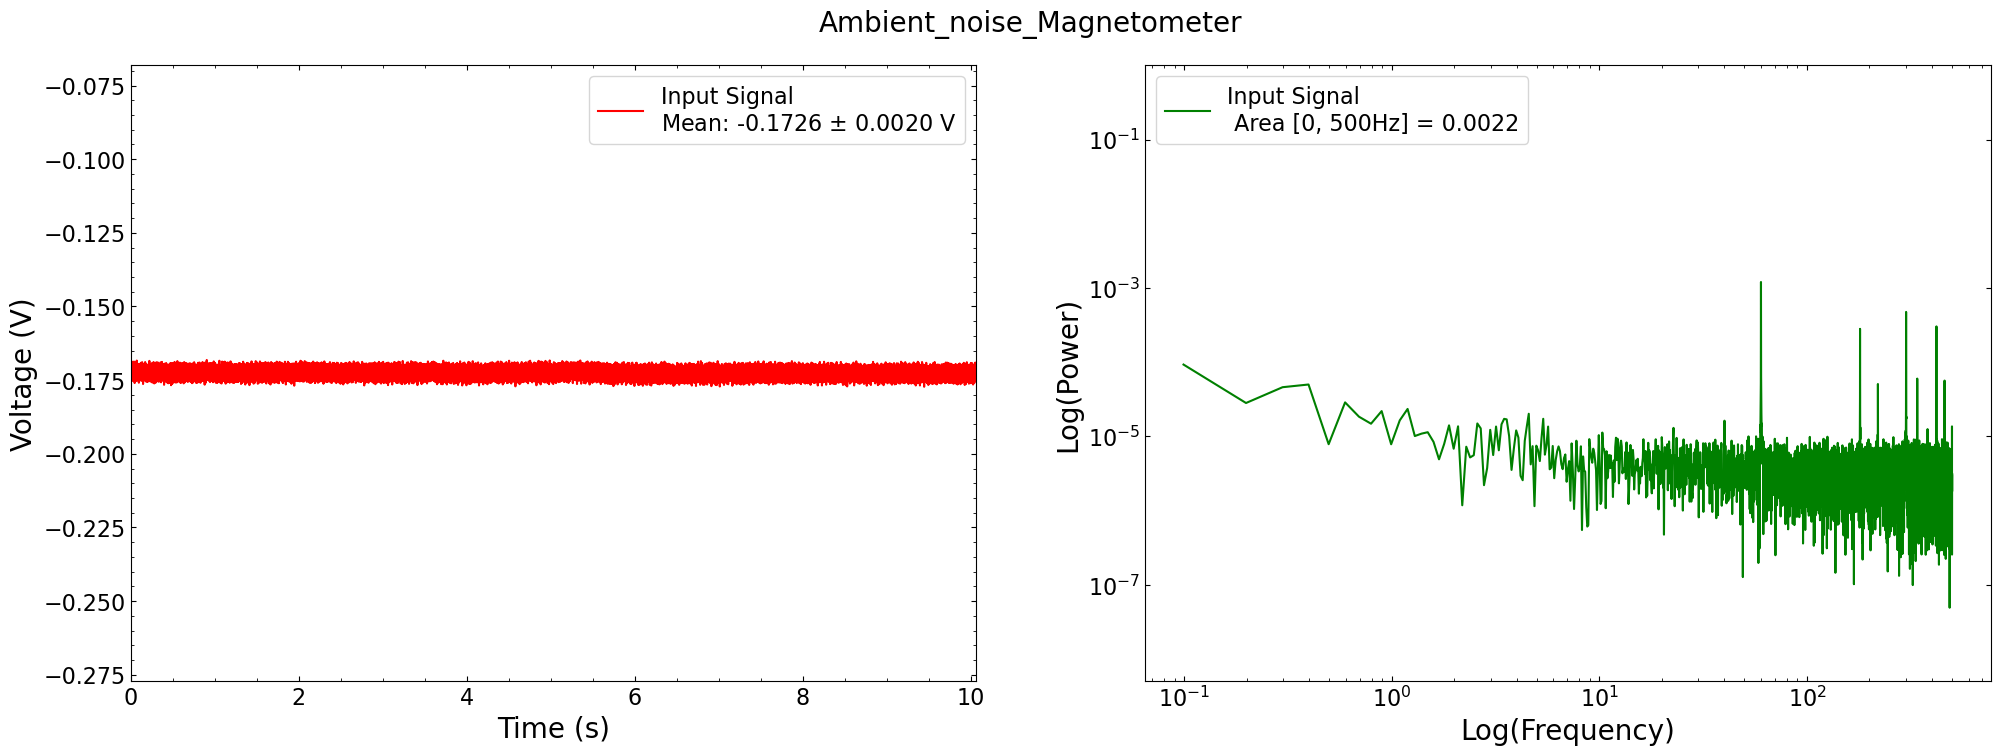

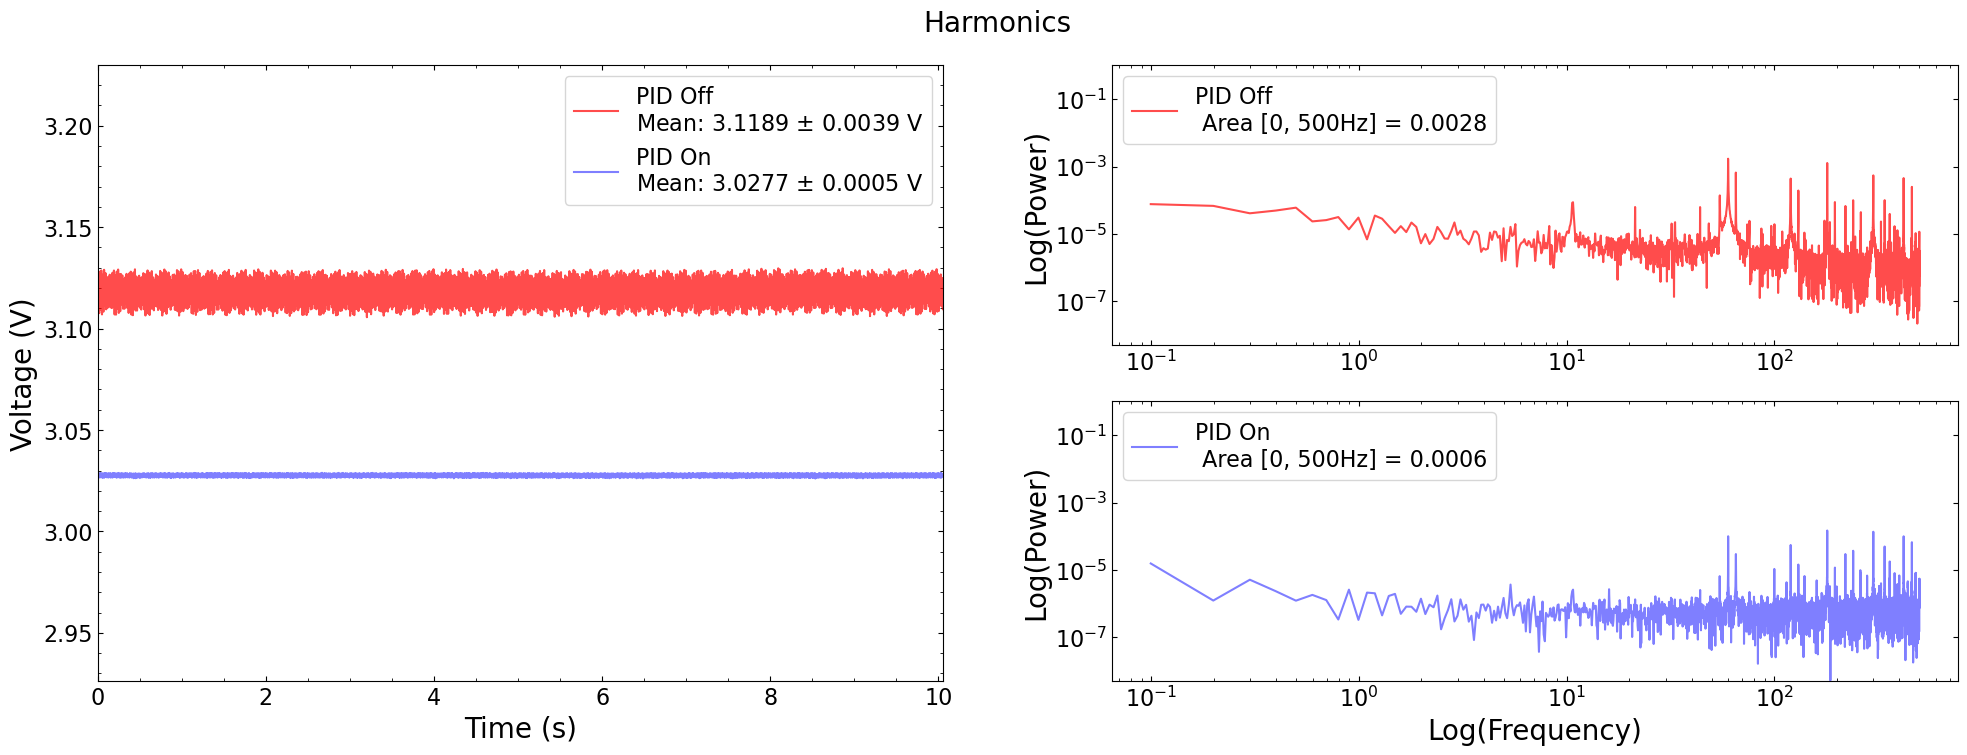

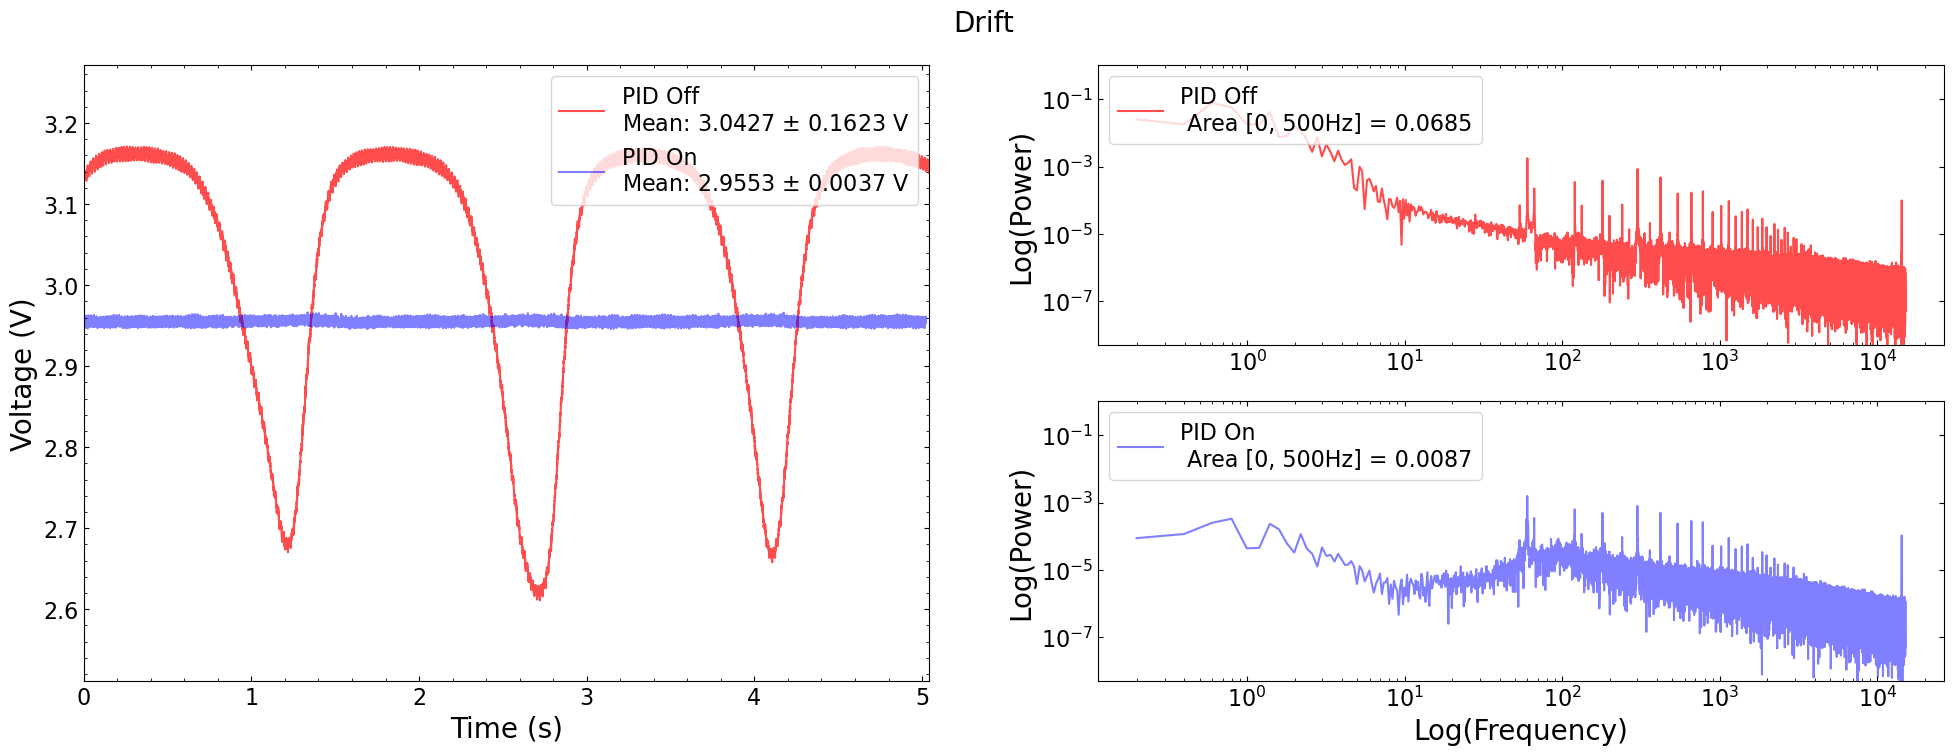

In [30]:
csv_single_list = [r"C:\Users\wuhai\Downloads\magnetometer_alone_10s.csv"]
title_single_list = ['Ambient_noise_Magnetometer']

csv_double_list = [[r"C:\Users\wuhai\Downloads\PID_off_noise_no_capacitor.csv",
                   r"C:\Users\wuhai\Downloads\PID_on_noise_no_capacitor_correct.csv"],
                   [r"C:\Users\wuhai\Downloads\MokuPIDControllerData_20230501_172729_pidoff_two_magnets.csv",
                   r"C:\Users\wuhai\Downloads\MokuPIDControllerData_20230501_172638_pidon_two_magnets.csv"]]
title_double_list = ['Harmonics', 'Drift']

pdf_list = []

log = True
save = True
cutoff_f = 500

for file, title in zip(csv_single_list, title_single_list):
    time_array, voltage_array, freq_array, power_array = load_data_single(file, title)
        
    if save:
        save_path = plot_data_fft_single(time_array, voltage_array, title, cutoff_f, log, save)
        pdf_list.append(save_path)
    else:
        plot_data_fft_single(time_array, voltage_array, title, area, log, save)

for file_pair, title in zip(csv_double_list, title_double_list):
    times1, data1, freq1, power1, times2, data2, freq2, power2 = load_data_double(file_pair, title)
    
    if save:
        save_path = plot_data_fft_double(times1, data1, times2, data2, title, cutoff_f, log, save)
        pdf_list.append(save_path)
    else:
        plot_data_fft_double(times1, data1, times2, data2, title, cutoff_f, log, save)

In [31]:
print(pdf_list)
if pdf_list:
    summary_path = r"C:\Users\wuhai\AMFS_figs\\Plot_summary_updated.pdf"
    merger = PdfWriter()
    for pdf in pdf_list:
        print(pdf)
        merger.append(pdf)
        os.remove(pdf)
    merger.write(summary_path)
    merger.close()

['C:\\Users\\wuhai\\AMFS_figs\\\\Ambient_noise_Magnetometer.pdf', 'C:\\Users\\wuhai\\AMFS_figs\\\\Harmonics.pdf', 'C:\\Users\\wuhai\\AMFS_figs\\\\Drift.pdf']
C:\Users\wuhai\AMFS_figs\\Ambient_noise_Magnetometer.pdf
C:\Users\wuhai\AMFS_figs\\Harmonics.pdf
C:\Users\wuhai\AMFS_figs\\Drift.pdf
